In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import convolve2d
from skimage.io import imread

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/MathematicalModelMethodImageProcessing')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/MathematicalModelMethodImageProcessing'

In [4]:
rootfolder = '/content/drive/MyDrive/Colab Notebooks/MathematicalModelMethodImageProcessing/Assignments'

Define the function to compute the kernel given the weights and the degree of the polynomial

In [5]:
def compute_2D_LPA_kernel(w, N):
    # compute the 2D LPA kernel for a given weights and polynomial degree
    # input:
    #   w: matrix containing the weights for the local LS problem
    #   N: degree of the polynomial approximation
    # return:
    #   g: the computed LPA kernel


    # window size is the lenght of the weight vector
    r, c = w.shape
    M = r*c

    # create the matrix T
    tx = np.linspace(0, 1, c)
    ty = np.linspace(0, 1, r)
    tx, ty = np.meshgrid(tx, ty)
    tx = tx.reshape(-1)
    ty = ty.reshape(-1)
    T = np.zeros((M,(N+1)**2))
    cnt = 0
    for i in range(N+1):
        for j in range(N-i+1):
            if i==0 and j==0:
                T[:, cnt] = np.ones(M)
            else:
                T[:, cnt] = tx**i * ty**j
            cnt = cnt + 1
    T = T[:, :cnt]

    # unroll the matrix of the weights
    w = w.reshape(-1)

    # generate the inverse of weights
    winv = 1/w

    # set to zero weights that are inf
    winv = np.where(np.isinf(winv), 0, winv)

    # define the weight matrix
    W = np.diag(w)
    Winv = np.diag(winv)

    ## construct the LPA kernel

    # comput the qr decomposition of WT
    Q, R = np.linalg.qr(W @ T)

    # define Qtilde
    Qtilde = Winv @ Q

    # adjust Qtilde with the weights matrix squared
    W2Qtilde = W**2 @ Qtilde

    # select the central row of W2Qtilde
    central_row_index = int(W2Qtilde.shape[0]/2)
    W2Qtilde_central_row = W2Qtilde[central_row_index, :]

    # compute the kernel
    g_bar = W2Qtilde_central_row @ Qtilde.T

    #reshape the kernel in a matrix
    g = g_bar.reshape(r, c)

    # flipping, since it is used in convolution
    g = np.flip(g)

    return g


Useful function for computing PSNR

In [7]:
def compute_psnr(Y_true, Y_pred):
  mse = np.square(np.subtract(Y_true,Y_pred)).mean()
  #max_signal = np.max(Y_true)
  max_signal = 1
  return 10* np.log10(max_signal**2 / mse)

Load the image and add the noise

In [8]:
img = imread(f'{rootfolder}/data/cameraman.png') / 255

sigma_noise = 20/255
noisy_img = img + np.random.normal(size=img.shape) * sigma_noise

psnr_noisy = compute_psnr(img, noisy_img)


Text(0.5, 1.0, 'Noisy image, PSNR = 22.13')

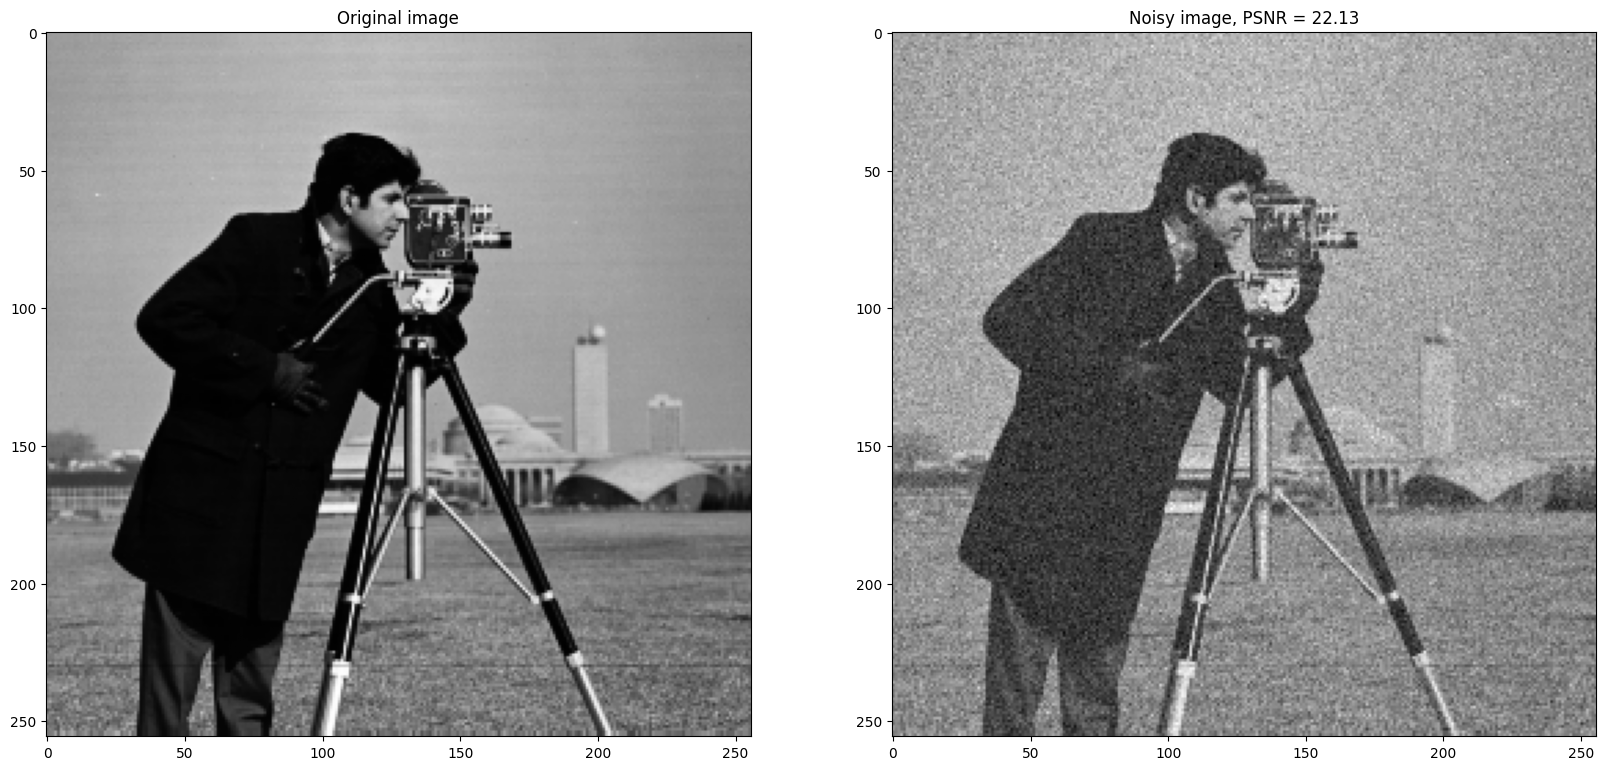

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')

LPA-ICI 2D
----------
Set the LPA-ICI parameters

In [10]:
# maximum degree of polynomial used for fitting
N = 1

# parameter for the confidence intervals in the ICI rule
Gamma = 2

# Set all the scale values
hmax = 21
all_h = np.arange(1, hmax+1)

Generate the LPA kernels for all the scales. Use centered weights.


In [11]:
all_g = []
for i, h in enumerate(all_h):
        # define the weights for the scale h symmetric
        # size of the weight MATRIX
        size = 2 * h + 1
        w = np.ones((size, size))

        # compute and store the kernel g
        g = compute_2D_LPA_kernel(w, N)
        all_g.append(g)

Initialize all the variables for the ICI rule

In [12]:
# initialize the estimate for each scale
yhat = np.zeros((img.shape))

# initialize the vector containing the best scale for each sample
best_scale = np.zeros(shape=yhat.shape)

# initialize the lower and upper bound matrices
lower_bounds = - np.inf * np.ones(shape=yhat.shape)
upper_bounds = np.inf * np.ones(shape=yhat.shape)

Loop over all the scales

In [13]:
for i, h in enumerate(all_h):
    g = all_g[i]

    # compute the estimate for the scale h
    yhat_h = convolve2d(noisy_img, g, mode='same')

    # compute the lower and upper bound of the confidence interval for the scale h
    lb = yhat_h - Gamma * sigma_noise * np.linalg.norm(g)
    ub = yhat_h + Gamma * sigma_noise * np.linalg.norm(g)

    # update the lower and upper bounds
    lower_bounds = np.maximum(lower_bounds, lb)
    upper_bounds = np.minimum(upper_bounds, ub)

    # identify for which samples h is the best scale according to the
    # ICI rule and update the best_scale vector accordingly
    # update best_scale
    best_scale[lower_bounds < upper_bounds] = h

    # update the estimate
    # update yhat
    yhat[lower_bounds < upper_bounds] = yhat_h[lower_bounds < upper_bounds]

Compute the PSNR

In [14]:
psnr = compute_psnr(img, yhat)

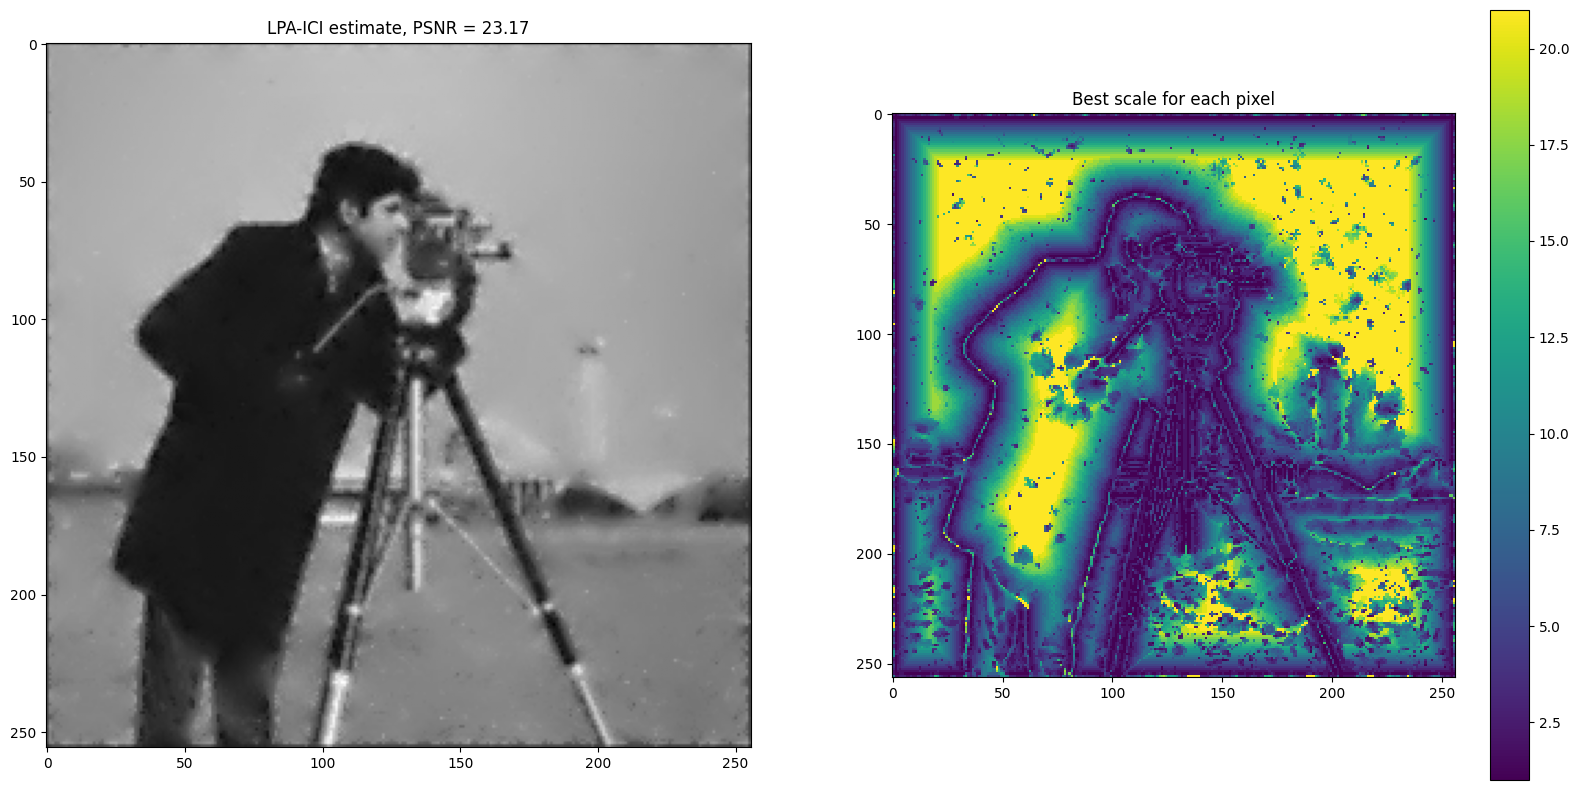

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(yhat, cmap='gray')
ax[0].set_title(f'LPA-ICI estimate, PSNR = {psnr:.2f}')

ax[1].imshow(best_scale)
ax[1].set_title('Best scale for each pixel')
fig.colorbar(ax[1].pcolormesh(best_scale), ax=ax[1])

Anisotropic LPA-ICI
------------------------
Set the parameters


Useful function for handling quadrant based weights

In [17]:
def quadrant_based_weights(theta, h):
  size = 2*h+1
  w = np.zeros((size, size))
  half = size //2
  # determine the quadrant based on theta
  if theta == 0: # first quadrant (top-right)
    w[:half + 1, half:] = 1
  elif theta == 1: # second quadrant (top-left)
    w[:half + 1, :half + 1] = 1
  elif theta == 2: # third quadrant (bottom-left)
    w[half:, :half + 1] = 1
  elif theta == 3: # fourth quadrant (bottomo-right)
    w[half:, half:] = 1
  return w

In [16]:
# maximum degree of polynomial used for fitting
N = 1

# parameter for the confidence intervals in the ICI rule
Gamma = 2

# Set all the scale values
hmax = 21
all_h = np.arange(1, hmax+1)

# set all the direction values
all_theta = np.arange(4)

Generate the LPA kernels for all the scales and all the directions

In [18]:
all_g = []

for theta in all_theta:

    all_g_theta = []
    for i, h in enumerate(all_h):
        # define the weights for the scale h and the direction theta
        w = quadrant_based_weights(theta, h)
        # compute and store the kernel g
        g = compute_2D_LPA_kernel(w, N)

        all_g_theta.append(g)

    all_g.append(all_g_theta)


/tmp/ipython-input-1120793977.py:35: RuntimeWarning: divide by zero encountered in divide
  winv = 1/w


Initialize all the variables

In [19]:
# initialize the estimate for each scale
yhat = np.zeros(img.shape)

# initialize the matrix of the aggregation weights
weights = np.zeros(img.shape)


Use the LPA-ICI to compute find the best scale for each direction and compute the finale estimates

In [20]:
# loop over all the directions
for theta in all_theta:
    # initialize the estimate for the direction theta
    yhat_theta = np.zeros(img.shape)

    # initialize the matrix all the variances for the direction theta
    var_theta = np.zeros(img.shape)

    # initialize the lower and upper bounds matrices
    lower_bounds = - np.inf * np.ones(shape=img.shape)
    upper_bounds = + np.inf * np.ones(shape=img.shape)

    # loop over all scales
    all_g_theta = all_g[theta]
    for i, h in enumerate(all_h):
        g = all_g_theta[i]

        # compute the estimate for the scale h
        yhat_h = convolve2d(noisy_img, g, mode='same')

        # compute the lower and upper bound of the confidence interval for the scale h
        lb = yhat_h - Gamma * sigma_noise * np.linalg.norm(g)
        ub = yhat_h + Gamma * sigma_noise * np.linalg.norm(g)

        # update the lower and upper bounds
        lower_bounds = np.maximum(lower_bounds, lb)
        upper_bounds = np.minimum(upper_bounds, ub)

        # update the estimate
        # update yhat_theta
        yhat_theta[lower_bounds < upper_bounds] = yhat_h[lower_bounds < upper_bounds]

        # update the matrix with the variances
        # update var_theta
        var_theta[lower_bounds < upper_bounds] = np.square(sigma_noise) * (np.linalg.norm(g))**2

    # update the estimates and the weights
    yhat = yhat + (yhat_theta/var_theta)
    weights = weights + (1/var_theta)

# compute the final estimates
yhat = yhat / weights

Compute the PSNR

In [21]:
psnr = compute_psnr(img, yhat)

Text(0.5, 1.0, 'LPA-ICI estimate, PSNR = 27.18')

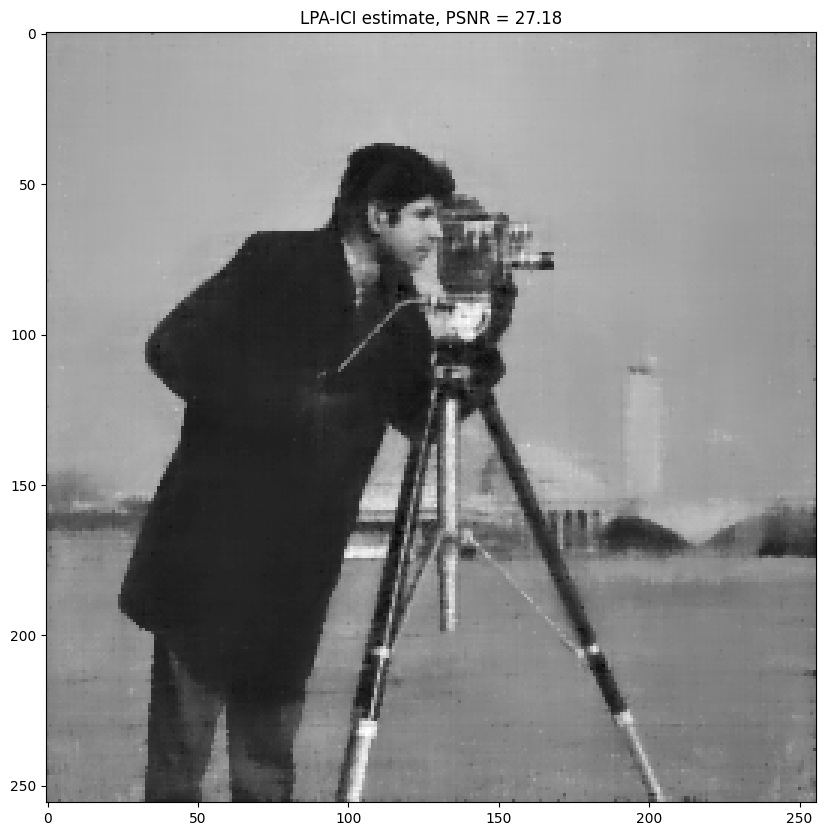

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(yhat, cmap='gray')
plt.title(f'LPA-ICI estimate, PSNR = {psnr:.2f}')
